Neuroevolution: Exercise 1 
=========
###### Artur Ganzha 10019651
---------	
###### Raul Gorek 10061333
---------	

### Aufgabe 1

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from IPython.display import clear_output

In [4]:
class Dice:
    def __init__(self, no_init=False):
        if no_init:
            self.value = 0
        else:
            self.value = random.randint(1,6)
    
    def roll(self):
        self.value = random.randint(1,6)

In [ ]:
wuerfel_liste = [Dice() for _ in range(100)]

t_start = time.perf_counter()
while sum([wuerfel.value for wuerfel in wuerfel_liste]) != 600:
    for wuerfel in wuerfel_liste:
        wuerfel.roll()
    if time.perf_counter() - t_start > 180:
        break

In [6]:
class Individual:
    def __init__(self, child=False, num=100):
        self.num = num
        if child:
            self.wuerfel_liste = np.zeros(shape=(num,))
            self.fitness = 0
        else:
            self.wuerfel_liste = np.random.randint(1, 7, size=(num,))
            self.fitness = np.count_nonzero(self.wuerfel_liste == 6)

    def mutate(self, p):
        mask = np.random.random(size=(self.num,)) <= p
        self.wuerfel_liste = np.multiply(self.wuerfel_liste, np.logical_not(mask))
        self.wuerfel_liste = np.add(
            np.multiply(np.random.randint(1, 7, size=mask.size), mask),
            self.wuerfel_liste,
        )
        self.fitness = np.count_nonzero(self.wuerfel_liste == 6)

In [7]:
popsize = 100
selection = 20
mutrate = 1
max_gen = 1000

population = [Individual() for _ in range(popsize)]

generation = 0
while generation < max_gen:
    fittest = sorted(population, key=lambda x: x.fitness, reverse=True)
    fittest = fittest[0:selection]
    if fittest[0].fitness == 100:
        break
    if generation % (max_gen*0.1) == 0:
        mutrate = mutrate * 0.5
    clear_output(wait=True)
    print(f"gen={generation}, mutrate={mutrate}, fittest={fittest[0].fitness}")
    #print(fittest[0].fitness)
    population = fittest[:]
    while len(population) < popsize:
        random.shuffle(fittest)
        mom = fittest.pop()
        dad = fittest.pop()
        child = Individual(child=True)
        for i in range(len(mom.wuerfel_liste)):
            child.wuerfel_liste[i] = mom.wuerfel_liste[i] if random.random() < 0.5 else dad.wuerfel_liste[i]
        child.mutate(mutrate)
        population.append(child)
        fittest.append(mom)
        fittest.append(dad)

    generation += 1

fittest = sorted(population, key=lambda x: x.fitness, reverse=True)
print(f"gen={generation}, mutrate={mutrate}, fittest={fittest[0].fitness}")

gen=400, mutrate=0.03125, fittest=99
gen=401, mutrate=0.03125, fittest=100


Man kann zum einen die Parameter anpassen (z.B. Mutationsrate, Selektionsgröße)
Zum anderen lässt sich durch einen Epsilon-Greedy ähnlichen Abfall der Mutationsrate erreichen, dass der Algorithmus am Anfang große Menge 6en erzeugt, wo sie noch nicht vorhanden sind und am Ende diese nicht mehr löscht, wo sie bereits bestehen.

Als Laufzeitoptimierung wurde eine Darstellung der Klasse - Individual mit Numpy Array verwendet.

### Aufgabe 2

In [8]:
import networkx as nx
import numpy as np
import random

In [9]:
def random_graph(nodes, edges):
    G = nx.Graph()
    G.add_nodes_from(np.arange(nodes))
    possible_edges = [(i, j) for i in range(nodes) for j in range(i + 1, nodes)]
    np.random.shuffle(possible_edges)
    G.add_edges_from(possible_edges[:edges])
    return G

In [10]:
class Individ:
    def __init__(self, num_nodes):
        self.gene = np.zeros(shape=(num_nodes,))

    def mutate(self, mutrate):
        mask = np.random.random(size=(len(self.gene),)) <= mutrate
        self.gene = np.logical_xor(self.gene, mask)

In [65]:
def fitness(ind: Individ, G: nx.Graph) -> float:
    nodes = np.argwhere(ind.gene == 1)
    clique_edges = [
        (nodes[i][0], nodes[j][0])
        for i in range(len(nodes))
        for j in range(i + 1, len(nodes))
    ]
    edges_in_graph = [edge for edge in clique_edges if edge in G.edges()]
    non_clique_penalty = (len(clique_edges) - len(edges_in_graph))
    is_clique_reward = len(G.nodes()) if non_clique_penalty == 0 else 0
    return sum(ind.gene) - non_clique_penalty + is_clique_reward

In [70]:
num_nodes = 60
num_edges = 1000
G = random_graph(num_nodes, num_edges)
len_max_cliq = len(max(list(nx.find_cliques(G)), key=len))
max_fit = len_max_cliq + num_nodes
possible_solutions = sorted([sorted(l) for l in nx.find_cliques(G) if len(l) == len_max_cliq])
print(max_fit, len_max_cliq, possible_solutions)

70 10 [[5, 7, 8, 10, 23, 36, 39, 40, 51, 53]]


gen=225, mutrate=0.1, fittest=70
gen=225, mutrate=0.1, fittest=70
[ 5  7  8 10 23 36 39 40 51 53] 10
Innerhalb der Lösungsmenge: True


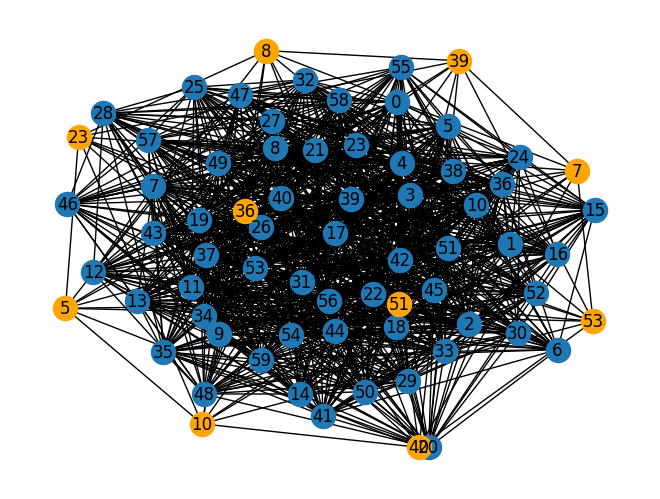

In [72]:
popsize = 1000
selection = 50
mutrate = 0.1
max_gen = 500
population = [Individ(num_nodes) for _ in range(popsize)]

generation = 0
while generation < max_gen:
    fittest = sorted(population, key=lambda x: fitness(x, G), reverse=True)
    fittest = fittest[0:selection]
    clear_output()
    print(f"gen={generation}, mutrate={mutrate}, fittest={fitness(fittest[0], G)}")
    if fitness(fittest[0], G) == max_fit:
        break
    population = fittest[:]
    while len(population) < popsize:
        random.shuffle(fittest)
        mom = fittest.pop()
        dad = fittest.pop()
        child = Individ(num_nodes)
        for i in range(len(mom.gene)):
            child.gene[i] = mom.gene[i] if random.random() < 0.5 else dad.gene[i]
        child.mutate(mutrate)
        population.append(child)
        fittest.append(mom)
        fittest.append(dad)

    generation += 1

fittest = sorted(population, key=lambda x: fitness(x,G), reverse=True)
print(f"gen={generation}, mutrate={mutrate}, fittest={fitness(fittest[0], G)}")
sub_nodes = np.argwhere(fittest[0].gene == 1).flatten()
print(sub_nodes, len(sub_nodes))
print(f"Innerhalb der Lösungsmenge: {any(np.array_equal(sublist, sub_nodes) for sublist in possible_solutions)}")
Sub = G.subgraph(sub_nodes)
nx.draw(G, with_labels=True)
nx.draw(Sub, with_labels=True, node_color='orange')